In [1]:
import tensorflow as tf
import os
import numpy as np

# Load and order images in array
images_path = "./train/images/"
images = os.listdir(images_path)
print(images)
ordered = [int(f[:-4]) for f in images]
ordered.sort()
ordered = [str(f)+".png" for f in ordered]
print(ordered)

# Make features and labels
def img_preprocess(path):
    imd = tf.image.decode_png(tf.io.read_file(path), channels=1)
    imd = tf.image.resize(imd, [360, 640])
    imd = tf.cast(imd, tf.float32)
    imd = imd / 255
    return imd

features = []
labels = []

for idx, im in enumerate(ordered):
    if idx+1 == len(ordered):
        break

    features.append(img_preprocess(images_path + im))
    labels.append(img_preprocess(images_path + ordered[idx+1]))
    if idx == 1:
        print(im)
        print(ordered[idx+1])

print("Features len: ", len(features))
print("Labels len: ", len(labels))
print("Shape: ", features[0].shape)

2024-04-24 10:39:29.403540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 10:39:29.739031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['89.png', '123.png', '105.png', '34.png', '48.png', '84.png', '135.png', '209.png', '69.png', '222.png', '142.png', '283.png', '118.png', '279.png', '291.png', '60.png', '10.png', '128.png', '176.png', '122.png', '121.png', '205.png', '173.png', '164.png', '178.png', '153.png', '68.png', '159.png', '113.png', '185.png', '195.png', '293.png', '83.png', '138.png', '91.png', '45.png', '127.png', '47.png', '206.png', '81.png', '194.png', '175.png', '155.png', '212.png', '271.png', '192.png', '59.png', '116.png', '158.png', '117.png', '172.png', '161.png', '169.png', '168.png', '240.png', '191.png', '147.png', '280.png', '38.png', '260.png', '17.png', '119.png', '58.png', '220.png', '77.png', '4.png', '181.png', '179.png', '140.png', '40.png', '73.png', '295.png', '12.png', '1.png', '244.png', '99.png', '44.png', '22.png', '79.png', '50.png', '148.png', '300.png', '225.png', '239.png', '100.png', '146.png', '156.png', '256.png', '284.png', '15.png', '9.png', '24.png', '160.png', '65.png', 

In [2]:
# split it into train and test datasets
data_split = 250
train_data = features[:data_split]
train_labels = labels[:data_split]
test_data = features[data_split:]
test_labels = labels[data_split:]

print(train_data[0].shape)
print(train_labels[0].shape)

#dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
#dataset = dataset.batch(5).prefetch(1)
#print(dataset)

print(len(train_data))
train_data = tf.expand_dims(train_data, 1)
train_labels = tf.expand_dims(train_labels, 1)
print(train_data.shape)


(360, 640, 1)
(360, 640, 1)
250
(250, 1, 360, 640, 1)


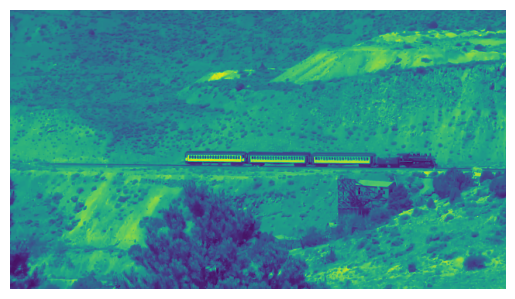

(360, 640, 1)


In [3]:
from matplotlib import pyplot as plt
plt.imshow(test_data[0])
plt.axis(False)
plt.show()
print(test_data[0].shape)


In [4]:
# Build model
myDO = 0.3

model = tf.keras.models.Sequential([
    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
        dropout=myDO,
        recurrent_dropout=myDO
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
        dropout=myDO,
        recurrent_dropout=myDO
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
        dropout=myDO,
        recurrent_dropout=myDO
    ),
    tf.keras.layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    ),
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

model.fit(train_data, train_labels, epochs=5)

Epoch 1/5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.34778333 0.339173   0.339173   ... 0.32134572 0.3112537  0.31398886]
 [0.35844335 0.36825758 0.3781821  ... 0.3506761  0.35844335 0.3574683 ]
 [0.39022696 0.39630097 0.40751895 ... 0.3791803  0.38318348 0.37320647]
 ...
 [0.18264    0.18264    0.18264    ... 0.59410936 0.5848693  0.6273794 ]
 [0.20104666 0.19900995 0.1956499  ... 0.63626176 0.63626176 0.6392024 ]
 [0.23728408 0.22670233 0.19431801 ... 0.6754915  0.66328615 0.65374583]]
(1, 360, 640, 1)


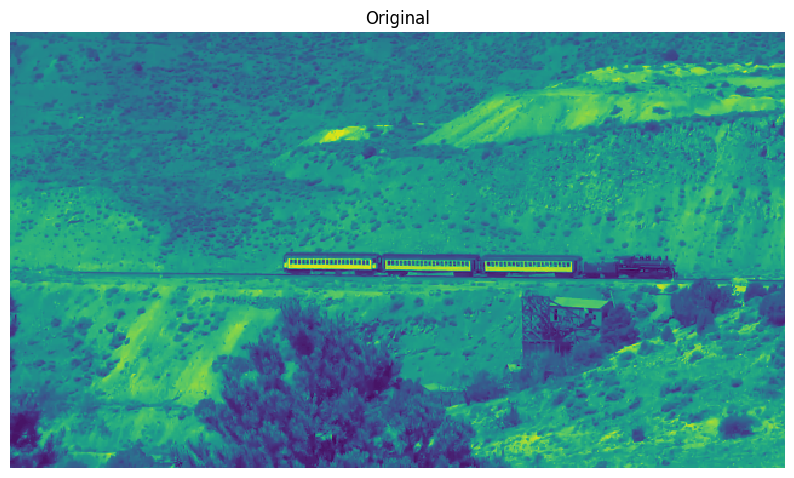

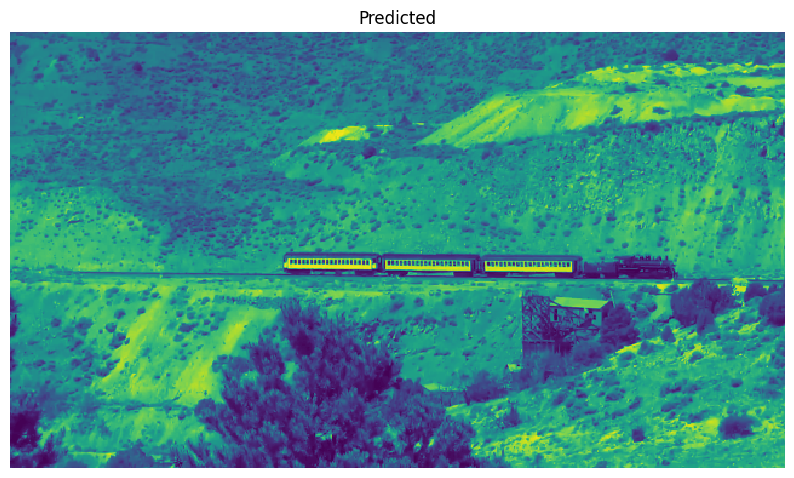

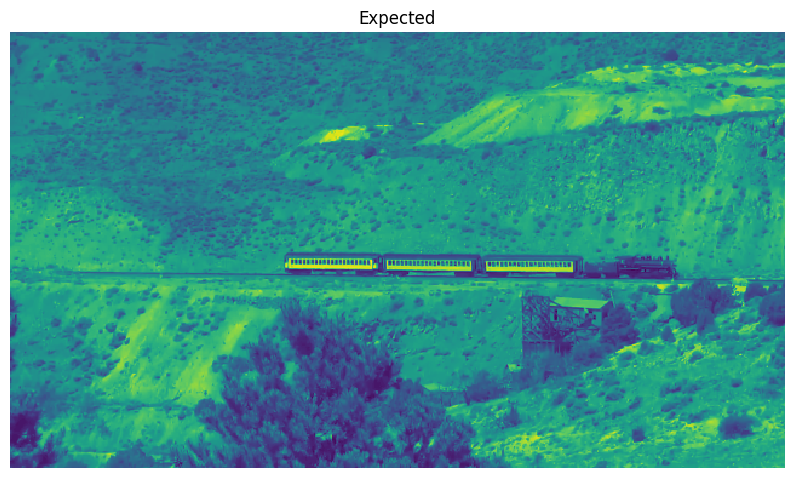

In [ ]:

from PIL import Image
from matplotlib import pyplot as plt

test = tf.expand_dims(test_data[0], 0)
pred = model.predict(test)
pred_img = pred[-1, :, :, -1]
print(pred_img)
print(pred.shape)

plt.figure(figsize=(10, 6))
plt.imshow(test_data[0][:, :, -1], interpolation='nearest')
plt.axis(False)
plt.title("Original")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(pred_img, interpolation='nearest')
plt.axis(False)
plt.title("Predicted")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(test_labels[0][:, :, -1], interpolation='nearest')
plt.axis(False)
plt.title("Expected")
plt.show()

In [ ]:
import mediapy as media

def prep_frames(data):
    frames = []
    for img in data:
        frames.append(img.numpy()[:, :, -1])
    return frames

media.show_video(prep_frames(train_data), fps=10, title="Train data")
media.show_video(prep_frames(test_data), fps=10, title="Test data")

In [ ]:

start = tf.expand_dims(train_data[0], 0)
imgs_to_pred = 10
frames = []

for i in range(imgs_to_pred):
    start = model.predict(start)
    frames.append(start)

for idx, f in enumerate(frames):
    frames[idx] = f[-1, :, :, -1]

media.show_image(train_data[0], title="Start")
media.show_video(frames, fps=10, title="Predicted video")

ValueError: Sequential model 'sequential_2' has already been configured to use input shape (None, 360, 640, 1). You cannot build it with input_shape (1, 360, 640, 1)